I am interested in working with RNAseq datasets including those that are publically available. This notebook is a first pass at accessing a public data set and doing some initial analysis including normalization, calculation of variance across genes and samples and visualization of 'expression' differences using heatmap plots. At the end of this notebook is the test code I wrote as I was learning to manipulate the data before downloading a larger data set. 

Some background:  
general process (see graphic/slide)
    steps in RNAseq analysis 
        read alignment to reference genome (STAR)
        align to reference genome (for GDC genome is GRCh38)
    read summarization
        map to known genes using annotation database (ENSEMBL)
        counting the reads that align to a given exon (dending on if you are strating w mRNA or total RNA) - today we will use
        TMP counts (transcrpts per kilobase millision - normalized according to gene length and/or millions of bps)
        *note: there are decisions to be made in terms of which counting format to use depedning on the downstream questions that will be asked. 

*Note:  Chat GPT and google assisted! 
a great intro paper on RNAseq:  https://pubmed.ncbi.nlm.nih.gov/36617463/


In [ ]:
#pip install seaborn

In [4]:
import requests
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#seaborn is a statistical data visualization package 
import seaborn as sns
import requests

Download RNAseq data from GDC (Genomic Data Commons)
Project:  TCGA_LIHC (RNA is total RNA from pateint tumor samples - each file is a sample)
https://portal.gdc.cancer.gov/projects/TCGA-LIHC (Cancer Genome Atlas)
In this project there are 371 samples that include RNAseq data

This code will retrieve 100 of those samples

This code block does two things: 
1. defines a function to send request
2. defines a function to write found files to local hard drive in .tsv format

**during class reset the download to 20! it will take close to 3min to download 100

In [5]:
#build the request using GDC API
GDC_API = "https://api.gdc.cancer.gov/"

# Project and data parameters I am requesting
PROJECT = "TCGA-LIHC"
FILE_TYPE = "Gene Expression Quantification"
DATA_CATEGORY = "Transcriptome Profiling"
EXPERIMENT_TYPE = "RNA-Seq"

# Set the directory for saving files, check that it exists and create one if needed
DATA_PATH = "data_TCGA_LIHC"
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Define functions for searching GDC 

def search_files():
    query_params = {
        "filters": json.dumps({
            "op": "and",
            "content": [
                {"op": "in", "content": {"field": "cases.project.project_id", "value": [PROJECT]}},
                {"op": "in", "content": {"field": "files.data_category", "value": [DATA_CATEGORY]}},
                {"op": "in", "content": {"field": "files.data_type", "value": [FILE_TYPE]}},
                {"op": "in", "content": {"field": "files.experimental_strategy", "value": [EXPERIMENT_TYPE]}},
            ]
        }),
        "fields": "file_id,file_name,cases.case_id",
        "format": "JSON",
        "size": "100"  # Limit to 100 files for now 
    }

#error checking 
    response = requests.get(GDC_API + "files", params=query_params)

    if response.status_code == 200: #successful request
        return response.json()["data"]["hits"]
    else:
        print("Error fetching files:", response.json()) # will return the error message if there is one 
        return []

#function to download selected files
def download_files(files):
    for file_info in files:
        file_id = file_info["file_id"]
    #using 'file name" from each individual - these become sample names
        file_name = file_info["file_name"] 
        file_path = os.path.join(DATA_PATH, file_name)  # Save file to the specific directory

        print(f"Downloading {file_name} to {file_path}...")

        # Create the URL
        download_url = f"{GDC_API}data/{file_id}"

        # download results
        response = requests.get(download_url, stream=True)
        if response.status_code == 200:
        #I am not sure why binary mode is preferred here
            with open(file_path, "wb") as file:
        # chunk response and then write that 'chunk'
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)
            print(f"{file_name} downloaded successfully.")
        else:
            print(f"Failed to download {file_name}. Status code: {response.status_code}")

# function calls 
if __name__ == "__main__":
    files = search_files()
    if files:
       print(f"Found {len(files)} files.")
       download_files(files)
    else:
       print("No files found.")




Found 100 files.
b575a230-b1ee-40b0-934a-64d73e3ca0af.rna_seq.augmented_star_gene_counts.tsv downloaded successfully.
bb4346c2-8149-4a5f-ae47-e6615bd61df2.rna_seq.augmented_star_gene_counts.tsv downloaded successfully.
fd81a481-5d7f-4e3a-a0ba-eba4f33591bc.rna_seq.augmented_star_gene_counts.tsv downloaded successfully.
f9c05849-4905-4ded-82ff-0f83be46b772.rna_seq.augmented_star_gene_counts.tsv downloaded successfully.
e615e629-be8c-4dce-a004-160e9d69b2db.rna_seq.augmented_star_gene_counts.tsv downloaded successfully.
af719f6c-4e97-4679-ab86-84aa810c7052.rna_seq.augmented_star_gene_counts.tsv downloaded successfully.
65518e95-98ee-4567-a9cb-e2ef4e9ad5ff.rna_seq.augmented_star_gene_counts.tsv downloaded successfully.
983ba5fa-d524-4ce9-af32-f4e4270b043b.rna_seq.augmented_star_gene_counts.tsv downloaded successfully.
8a6fcf82-a349-4f74-9969-65a056fe9577.rna_seq.augmented_star_gene_counts.tsv downloaded successfully.
fe42792f-4116-4e5f-8db3-678b74cfd263.rna_seq.augmented_star_gene_counts.ts

We now have 100 tsv files // check one out 
*note: I requested the RNAseq data which includes normalized values from several approaches
There is addtional data associated with the project that can be used but not today! 

Next step is to iterate through the 100 .tsv files and combine the data into one dataframe that will have the following structure: 
columns: 
    Ensemble_ID (index)
    tpm_unstranded (tmp normalized STAR data)
    sample/file names become column headings

stored this locally as:  combined_tpm_data.csv

Error Handling:
If a file is missing the required columns (gene_name or tpm_unstranded), it is skipped, and a warning is printed.

In [7]:
# Path to the folder containing the TSV files
input_folder = "data_TCGA_LIHC"  

# Initialize an empty list to store data
combined_data = []

# Loop through all files in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".tsv"):  # Only process TSV files
        file_path = os.path.join(input_folder, filename)
        print(f"Processing file: {filename}")
        
        # Load the TSV file into a DataFrame
        try:
            df = pd.read_csv(file_path, sep="\t", comment="#")  # removes tabs and skips comments
        # 
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue

        # Filter rows to include only those with valid Ensembl IDs
        if 'gene_id' in df.columns and 'tpm_unstranded' in df.columns:
            df = df[['gene_id', 'tpm_unstranded']].copy()
            df = df[df['gene_id'].str.startswith('ENSG')]  # Keep only rows where gene_id starts with "ENSG"

            # Rename columns for clarity
            df.rename(columns={'gene_id': 'Ensembl_ID', 'tpm_unstranded': filename}, inplace=True)
            combined_data.append(df)
        else:
            print(f"Skipping {filename} - Missing required columns")

".rna_seq.augmented_star_gene_counts.tsv"


# Merge all data into a single DataFrame based on Ensembl_ID
if combined_data:
    combined_df = combined_data[0]
    for df in combined_data[1:]:
        combined_df = pd.merge(combined_df, df, on='Ensembl_ID', how='outer')
    print("Combined DataFrame created successfully.")

    # Rename column headers by removing the string ".rna_seq.augmented_star_gene_counts.tsv"
    combined_df.columns = combined_df.columns.str.replace(".rna_seq.augmented_star_gene_counts.tsv", "", regex=False)

    # Save the modified DataFrame as a CSV file
    output_file = "combined_tpm_data.csv"  # Name of output file
    combined_df.to_csv(output_file, index=False)
    print(f"DataFrame saved to {output_file}")


else:
    combined_df = pd.DataFrame()  # Empty DataFrame if no data was combined
    print("No data was combined. Check for missing or incompatible files.")




Processing file: 9ea1ae11-2d1e-4d55-bbc6-c6f136041c6d.rna_seq.augmented_star_gene_counts.tsv
Processing file: 9f5f7f86-89e6-4a9c-a5a5-32c46c5e2baf.rna_seq.augmented_star_gene_counts.tsv
Processing file: e615e629-be8c-4dce-a004-160e9d69b2db.rna_seq.augmented_star_gene_counts.tsv
Processing file: c54543f5-6a3a-4ec6-bf6e-9d423ddf54f9.rna_seq.augmented_star_gene_counts.tsv
Processing file: 6c8ba378-3d51-46a8-ac10-41652da21459.rna_seq.augmented_star_gene_counts.tsv
Processing file: 39546419-4ab2-4d0f-b620-eb18c4583853.rna_seq.augmented_star_gene_counts.tsv
Processing file: 96aa5d94-f2d7-4173-8477-ccbfaa3451b5.rna_seq.augmented_star_gene_counts.tsv
Processing file: 70b45a47-52ad-40a1-97db-ef145353922e.rna_seq.augmented_star_gene_counts.tsv
Processing file: 65d83cea-ef9b-4148-88c5-c09192289e83.rna_seq.augmented_star_gene_counts.tsv
Processing file: 11795d2c-eeb4-4d71-ba35-0ceac205bd18.rna_seq.augmented_star_gene_counts.tsv
Processing file: c0b92413-c9f7-4a67-9ca7-cb065ac9c407.rna_seq.augmente


Confirm the df structure can be read from the stored CSV file and the structure is intact after modifying the sample names 



In [8]:
# To confirm the file is created and check the first few rows
df=pd.read_csv("combined_tpm_data.csv", index_col="Ensembl_ID")
print(df.head())
print(len(combined_df))


                    9ea1ae11-2d1e-4d55-bbc6-c6f136041c6d  \
Ensembl_ID                                                 
ENSG00000000003.15                               38.6842   
ENSG00000000005.6                                 0.0419   
ENSG00000000419.13                               58.4790   
ENSG00000000457.14                                6.0883   
ENSG00000000460.17                                3.3026   

                    9f5f7f86-89e6-4a9c-a5a5-32c46c5e2baf  \
Ensembl_ID                                                 
ENSG00000000003.15                              106.4902   
ENSG00000000005.6                                 0.0941   
ENSG00000000419.13                               61.3787   
ENSG00000000457.14                                4.1460   
ENSG00000000460.17                                3.3611   

                    e615e629-be8c-4dce-a004-160e9d69b2db  \
Ensembl_ID                                                 
ENSG00000000003.15                    

Access the .csv file and build dataframe
Check length - should be 60,660

In [9]:
#create df from csv file 
#set index column to Ensemble ID 
tpm_data =pd.read_csv("combined_tpm_data.csv", index_col="Ensembl_ID")
print(tpm_data.head)
print(len(tpm_data))

<bound method NDFrame.head of                     9ea1ae11-2d1e-4d55-bbc6-c6f136041c6d  \
Ensembl_ID                                                 
ENSG00000000003.15                               38.6842   
ENSG00000000005.6                                 0.0419   
ENSG00000000419.13                               58.4790   
ENSG00000000457.14                                6.0883   
ENSG00000000460.17                                3.3026   
...                                                  ...   
ENSG00000288669.1                                 0.0000   
ENSG00000288670.1                                10.7060   
ENSG00000288671.1                                 0.0000   
ENSG00000288674.1                                 0.0128   
ENSG00000288675.1                                 0.2207   

                    9f5f7f86-89e6-4a9c-a5a5-32c46c5e2baf  \
Ensembl_ID                                                 
ENSG00000000003.15                              106.4902   
ENSG00000

normalize the tpm data using log2 


In [10]:
# Apply log2 normalization to the TPM values (add 1 to avoid log of zero)
#compress the range of values
log_normalized_tpm_df = np.log2(tpm_data + 1)

# Save the normalized DataFrame to a new CSV file
output_file = "log_normalized_tpm_data.csv"  
log_normalized_tpm_df.to_csv(output_file, index=False)

print(f"Log-normalized TPM values saved to {output_file}")
print(log_normalized_tpm_df.head)

Log-normalized TPM values saved to log_normalized_tpm_data.csv
<bound method NDFrame.head of                     9ea1ae11-2d1e-4d55-bbc6-c6f136041c6d  \
Ensembl_ID                                                 
ENSG00000000003.15                              5.310493   
ENSG00000000005.6                               0.059217   
ENSG00000000419.13                              5.894308   
ENSG00000000457.14                              2.825440   
ENSG00000000460.17                              2.105209   
...                                                  ...   
ENSG00000288669.1                               0.000000   
ENSG00000288670.1                               3.549176   
ENSG00000288671.1                               0.000000   
ENSG00000288674.1                               0.018349   
ENSG00000288675.1                               0.287709   

                    9f5f7f86-89e6-4a9c-a5a5-32c46c5e2baf  \
Ensembl_ID                                                 
ENSG00

Caluclate gene varience across samples 

In [11]:
#gene variance calc using
gene_variance = log_normalized_tpm_df.var(axis=1) #axis = 1 so we compute varience acrosse samples for each gene
gene_variance 

Ensembl_ID
ENSG00000000003.15    0.789300
ENSG00000000005.6     0.083857
ENSG00000000419.13    0.527809
ENSG00000000457.14    0.461079
ENSG00000000460.17    0.839117
                        ...   
ENSG00000288669.1     0.006081
ENSG00000288670.1     0.399021
ENSG00000288671.1     0.000000
ENSG00000288674.1     0.001498
ENSG00000288675.1     0.118605
Length: 60660, dtype: float64

Visualize the distribution of variances across the full dataset 

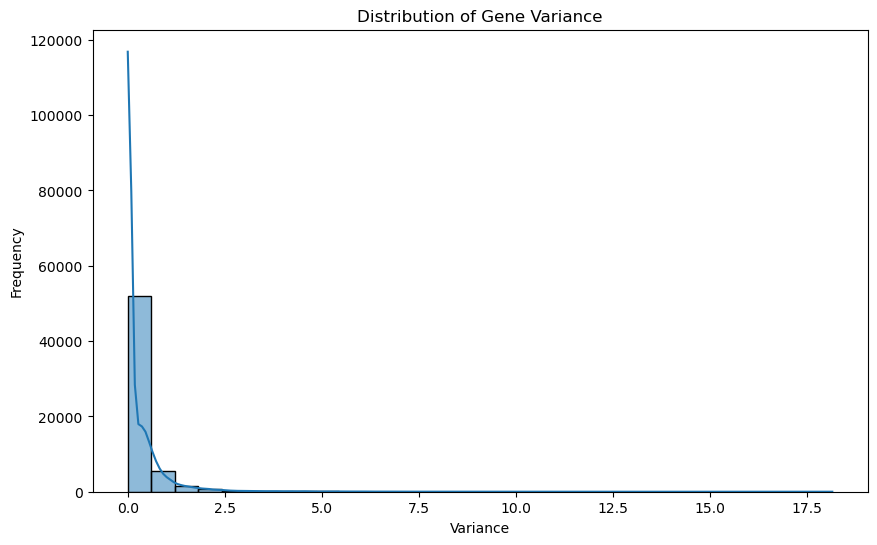

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(gene_variance, bins=30, kde=True)
plt.title("Distribution of Gene Variance")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.show()

Select the top N most variant genes 
N = 20 genes to be returned from the 60660 gene IDs 


In [15]:
top_percent = int(0.00033 * len(gene_variance))
#called top genes b/c we will also have top samples for each gene
top_genes = gene_variance.nlargest(top_percent)
top_genes 
print(len(top_genes))

20


select the top N most varient samples for those genes
N = 20 samples from the 100 we downloaded

In [16]:
#Calculate variance for each sample (column)
sample_variance = log_normalized_tpm_df.var(axis=0)
top_sample_percent = int(0.2 * len(sample_variance))  
top_samples = sample_variance.nlargest(top_sample_percent)
top_samples




e615e629-be8c-4dce-a004-160e9d69b2db    4.034195
19dc74d9-a307-4991-8723-a570de15858d    3.949513
7df90db3-232d-4e82-b960-7dcee63635bd    3.937150
c4885dd1-1f37-48d2-b6c2-f6ac660c511e    3.826850
b119d1ea-21b8-408c-b2be-c8d68de6101c    3.664242
b575a230-b1ee-40b0-934a-64d73e3ca0af    3.602420
4fd965ea-f490-456a-83fc-38cf9be8f44e    3.530228
39546419-4ab2-4d0f-b620-eb18c4583853    3.508296
6452215d-e0ae-482f-8f32-963e7017bec0    3.426572
96aa5d94-f2d7-4173-8477-ccbfaa3451b5    3.377265
50cae4c7-fef8-40fa-a3ed-d14a34eb6103    3.375849
fe42792f-4116-4e5f-8db3-678b74cfd263    3.374891
4e58c985-012a-4846-97f6-80dac0cae0b4    3.359659
302fb528-5824-4e20-8cc3-1001aac9bd4b    3.334417
a4bcd2df-1155-4528-86bc-232b0349c1a0    3.305153
ae0d8ed3-e789-4ef8-b0c2-58e8ad7a3962    3.298067
cf9a78e4-5487-4366-94b6-4b85dfef5e4d    3.294546
be8ac5cf-54d6-4c73-8ab9-fc3b7f7e93e6    3.289696
927fbb8a-acc0-4f3a-9d58-20650e187554    3.280241
7e02abeb-88a6-4d15-8d27-7f7d05d22fee    3.272863
dtype: float64

Take a subset of the dataframe that corrisponds to the top variant genes and samples - as calculated above 

In [17]:

df_top_genes_samples = log_normalized_tpm_df.loc[top_genes.index, top_samples.index]
print(df_top_genes_samples.head)
print(len(df_top_genes_samples))

<bound method NDFrame.head of                     e615e629-be8c-4dce-a004-160e9d69b2db  \
Ensembl_ID                                                 
ENSG00000172016.16                              0.000000   
ENSG00000160868.15                              3.274947   
ENSG00000130649.10                              3.784996   
ENSG00000164266.11                              7.901521   
ENSG00000132693.12                              8.109185   
ENSG00000198074.10                              9.819999   
ENSG00000188257.12                              3.463112   
ENSG00000173432.12                              4.985642   
ENSG00000255974.8                               6.239301   
ENSG00000118785.14                              6.395981   
ENSG00000211896.7                              10.666277   
ENSG00000113600.11                              4.433634   
ENSG00000129824.16                              8.809572   
ENSG00000211592.8                              12.436625   
ENSG000001

Plot these results to heatmap 

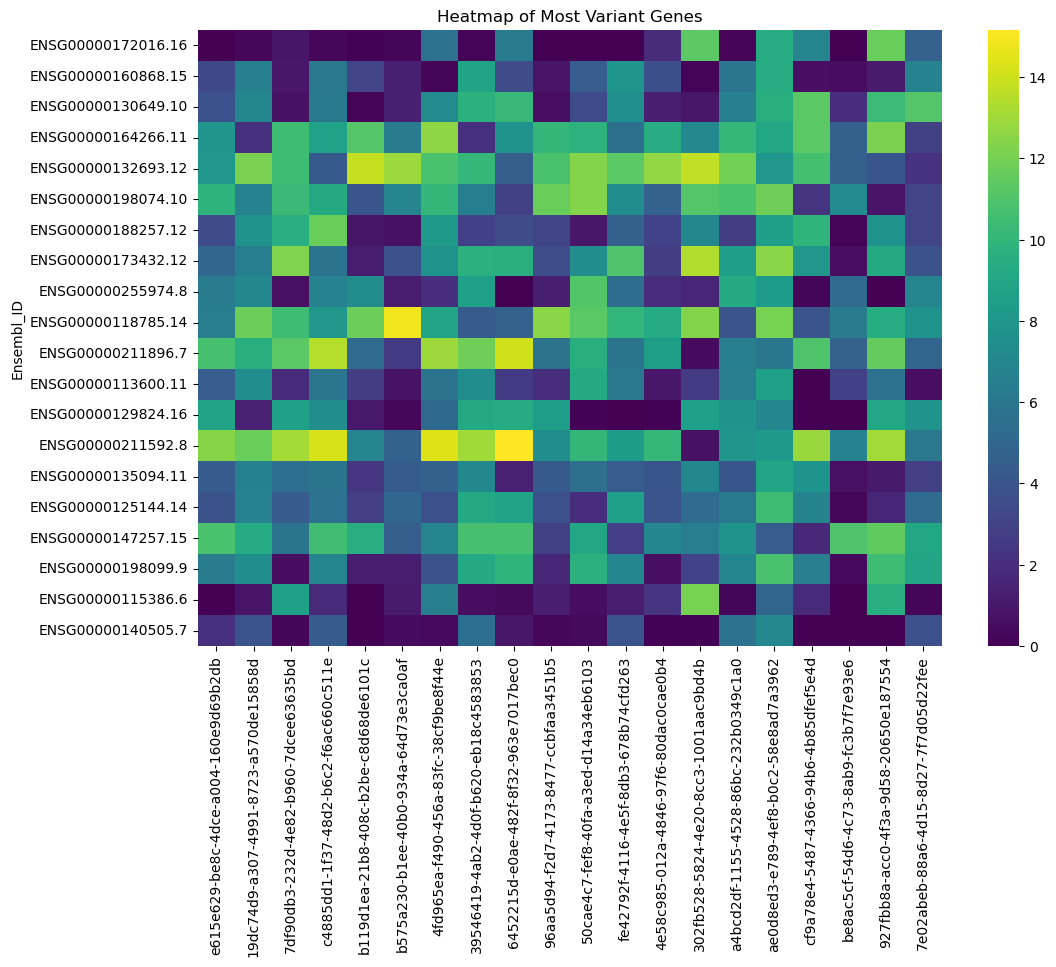

In [18]:
#Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_top_genes_samples, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title("Heatmap of Most Variant Genes")
plt.show()

Can cluster the top variences for samples and genes 

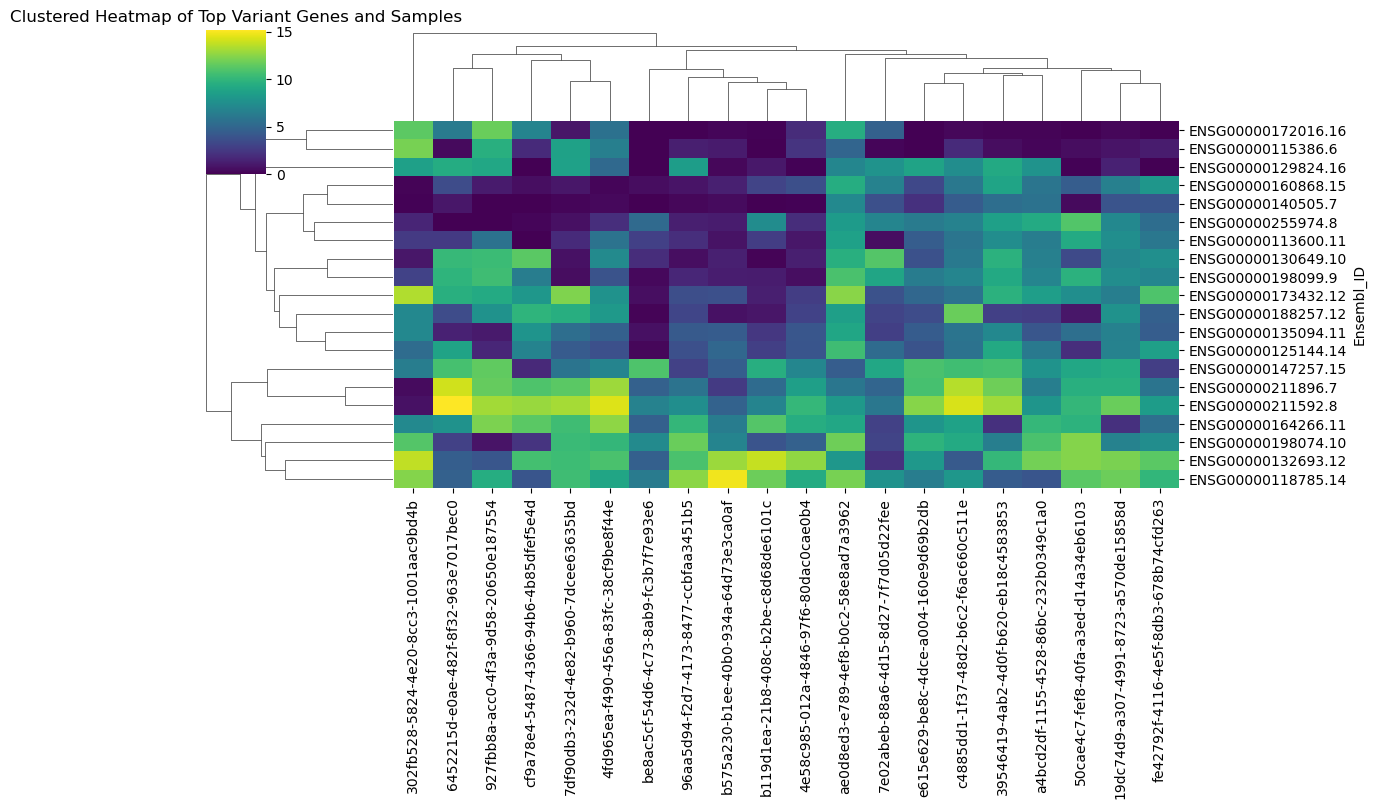

In [19]:
#cluster rows and columns
sns.clustermap(df_top_genes_samples, cmap="viridis", col_cluster=True, row_cluster=True, figsize=(12, 8))
plt.title("Clustered Heatmap of Top Variant Genes and Samples")
plt.show()

Principal Component Analysis (PCA) is a commonly used technique in RNA-Seq data analysis to explore the variance and relationships between samples. PCA reduces high-dimensional data (e.g., expression of thousands of genes across samples) into a few principal components (PCs) to visualize major patterns in the data.

Explained variance: PC1 = 20.16%, PC2 = 9.37%


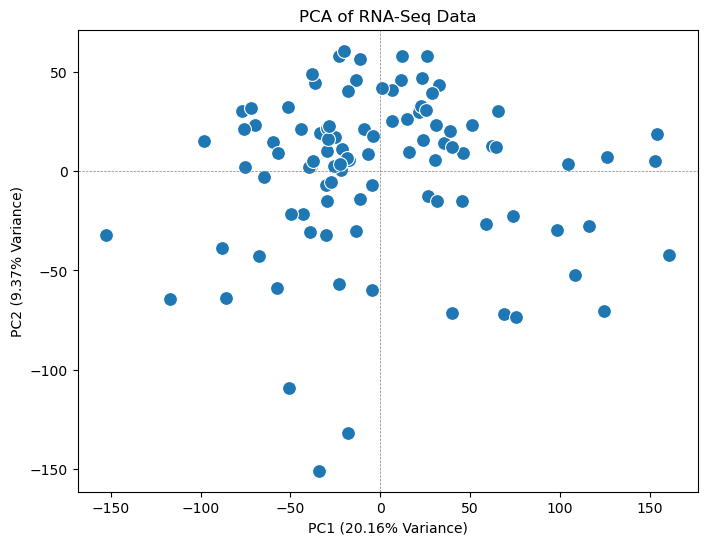

In [20]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)  # Keep the first 2 principal components
pca_result = pca.fit_transform(log_normalized_tpm_df.T)  # Transpose to make samples rows

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=log_normalized_tpm_df.columns)

# Explained variance
explained_variance = pca.explained_variance_ratio_ * 100
print(f"Explained variance: PC1 = {explained_variance[0]:.2f}%, PC2 = {explained_variance[1]:.2f}%")

# Visualize PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100)

# Annotate each sample
#for sample in pca_df.index:
    #plt.text(pca_df.loc[sample, 'PC1'], pca_df.loc[sample, 'PC2'], sample, fontsize=10)

plt.title('PCA of RNA-Seq Data')
plt.xlabel(f"PC1 ({explained_variance[0]:.2f}% Variance)")
plt.ylabel(f"PC2 ({explained_variance[1]:.2f}% Variance)")
plt.axhline(0, linestyle='--', color='gray', linewidth=0.5)
plt.axvline(0, linestyle='--', color='gray', linewidth=0.5)
plt.show()


Testing code using a very small data set generated using a random number generator.  An introduction to full process and code used. 

Chat GPT and google assisted! 

In [79]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#seaborn is a statistical data visualization package 
import seaborn as sns


# Step 1: create dataframe containing a small dataset  
np.random.seed(42) #passing in 42 here generates same number set each time for testing
#to produce different numbers 
#np.random.seed()

#create matrix of genes and sample names - using numbers
#make list of numbers between 1 and 100 - labled "gene"
genes = [f"Gene_{i}" for i in range(1, 101)]
#make list of number betweeen 1 and 10 labeled samples 
samples = [f"Sample_{i}" for i in range(1, 11)]
#create data frame that is 100 x 10  - using random nuymbers and labels created above
raw_counts = pd.DataFrame(np.random.poisson(100, (100, 10)), index=genes, columns=samples)
print(raw_counts.head())




        Sample_1  Sample_2  Sample_3  Sample_4  Sample_5  Sample_6  Sample_7  \
Gene_1        96       107        88       103       111        90        94   
Gene_2        99        90       103       103        94       105        86   
Gene_3       103        84        76        97       111        93        87   
Gene_4        96       113        95        94       107       114        86   
Gene_5        94       116        97        91        94       118       104   

        Sample_8  Sample_9  Sample_10  
Gene_1        98       103         94  
Gene_2        92        94        101  
Gene_3       108       106        108  
Gene_4       108       108        101  
Gene_5       110       115         94  


Step 2: Normalize the data (log normalization)

Apply log2 for normalizing data 

In [80]:

#Adding a pseudocount of 1 to avoid log(0)
log_normalized_counts = np.log2(raw_counts + 1)

print(log_normalized_counts.head())

        Sample_1  Sample_2  Sample_3  Sample_4  Sample_5  Sample_6  Sample_7  \
Gene_1  6.599913  6.754888  6.475733  6.700440  6.807355  6.507795  6.569856   
Gene_2  6.643856  6.507795  6.700440  6.700440  6.569856  6.727920  6.442943   
Gene_3  6.700440  6.409391  6.266787  6.614710  6.807355  6.554589  6.459432   
Gene_4  6.599913  6.832890  6.584963  6.569856  6.754888  6.845490  6.442943   
Gene_5  6.569856  6.870365  6.614710  6.523562  6.569856  6.894818  6.714246   

        Sample_8  Sample_9  Sample_10  
Gene_1  6.629357  6.700440   6.569856  
Gene_2  6.539159  6.569856   6.672425  
Gene_3  6.768184  6.741467   6.768184  
Gene_4  6.768184  6.768184   6.672425  
Gene_5  6.794416  6.857981   6.569856  


#.var is a functoin you can apply to 
gene_variance = log_normalized_counts.var(axis=1) #axis = 1 so we compute varience acrosse samples for each gene
gene_variance 

In [81]:
#.var is a functoin you can apply to 
gene_variance = log_normalized_counts.var(axis=1) #axis = 1 so we compute varience acrosse samples for each gene
gene_variance 

Gene_1      0.011536
Gene_2      0.009093
Gene_3      0.033139
Gene_4      0.017289
Gene_5      0.021137
              ...   
Gene_96     0.020679
Gene_97     0.020642
Gene_98     0.028006
Gene_99     0.015614
Gene_100    0.028166
Length: 100, dtype: float64

Visualize the distribution of variances

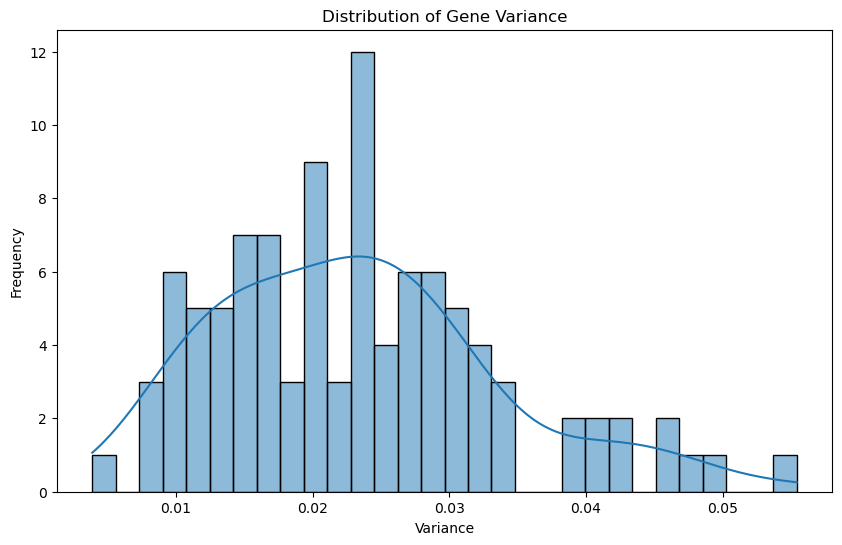

In [82]:

plt.figure(figsize=(10, 6))
sns.histplot(gene_variance, bins=30, kde=True)
plt.title("Distribution of Gene Variance")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.show()


Eventually we will want to look only at the genes that show the most variance amonst samples so we can practice it here by looking for the top 50% 

In [83]:
#asking for the top values 
top_percent = int(0.2 * len(gene_variance))
# .nlargest returns specific number of the df rows in descending order
top_genes = gene_variance.nlargest(top_percent)
top_genes


Gene_86    0.055414
Gene_16    0.048707
Gene_61    0.047006
Gene_13    0.046411
Gene_79    0.045205
Gene_89    0.042632
Gene_55    0.042306
Gene_70    0.040795
Gene_46    0.040450
Gene_22    0.039636
Gene_20    0.038752
Gene_44    0.034086
Gene_85    0.033977
Gene_3     0.033139
Gene_72    0.032597
Gene_76    0.031739
Gene_6     0.031631
Gene_43    0.031486
Gene_53    0.031209
Gene_75    0.030746
dtype: float64

Next we generate a heatmap of the varience 

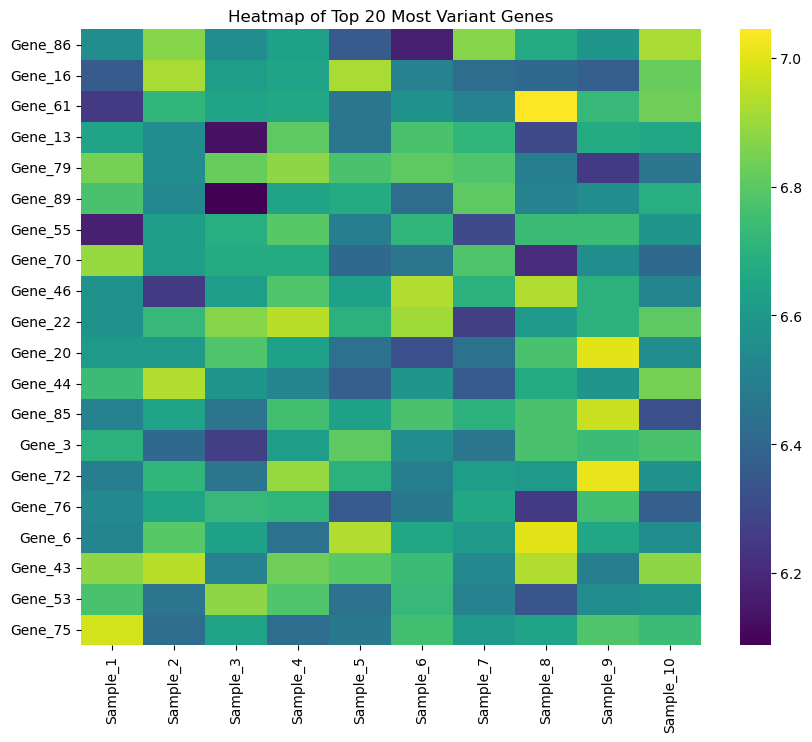

In [84]:
# Visualize the expression levels of the top variant genes as a heatmap
#create index using top gene names from above
top_gene_names = top_genes.index
plt.figure(figsize=(10, 8))
#seaborn function to create heatmap
sns.heatmap(log_normalized_counts.loc[top_gene_names], cmap='viridis', yticklabels=top_gene_names)
plt.title(f"Heatmap of Top {top_percent} Most Variant Genes")
plt.show()